In [141]:
%load_ext autoreload
%autoreload complete

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
from src.data.protests import get_climate_protests, get_climate_queries

protests = get_climate_protests()

In [143]:
protests.head()

,event_date,sub_event_type,assoc_actor_1,admin1,location,notes,weekday,region_code,size
770,2022-11-05,Peaceful protest,FFF: Fridays for Future; Students (Germany),Sachsen,Dresden,"On 5 November 2022, members of FFF (including ...",Saturday,SN,NaN
1078,2022-10-12,Peaceful protest,FFF: Fridays for Future; Students (Germany),Nordrhein-Westfalen,Euskirchen,"Around 12 October 2022 (as reported), more tha...",Wednesday,NW,100.0
1165,2022-10-07,Peaceful protest,FFF: Fridays for Future; Students (Germany),Nordrhein-Westfalen,Aachen,"On 7 October 2022, about 50 activists affiliat...",Friday,NW,50.0
1167,2022-10-07,Peaceful protest,FFF: Fridays for Future; Students (Germany),Berlin,Berlin,"On 7 October 2022, activists affiliated with t...",Friday,BE,NaN
1168,2022-10-07,Peaceful protest,FFF: Fridays for Future; Students (Germany),Sachsen,Dresden,"On 7 October 2022, activists affiliated with t...",Friday,SN,NaN


Sachsen 16 9


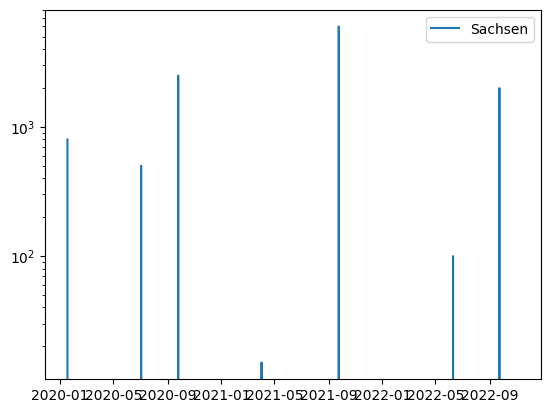

Nordrhein-Westfalen 135 61


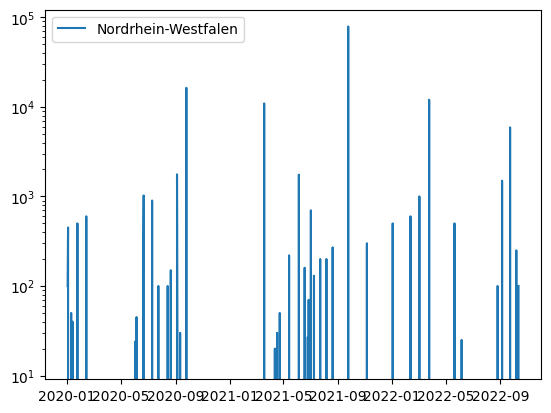

Berlin 25 25


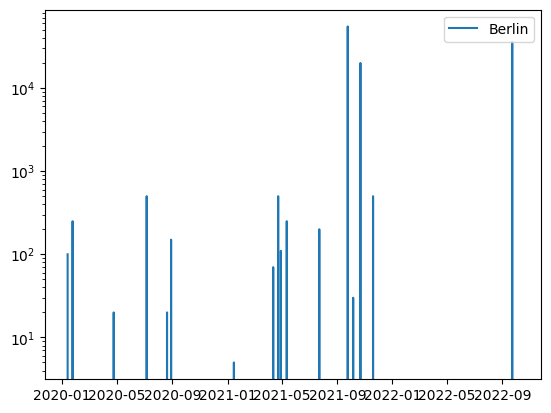

Niedersachsen 77 26


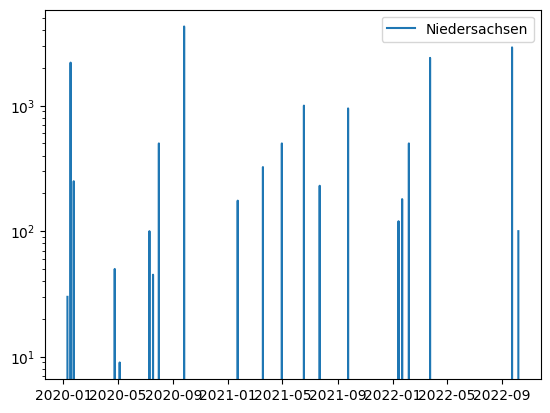

Bayern 96 44


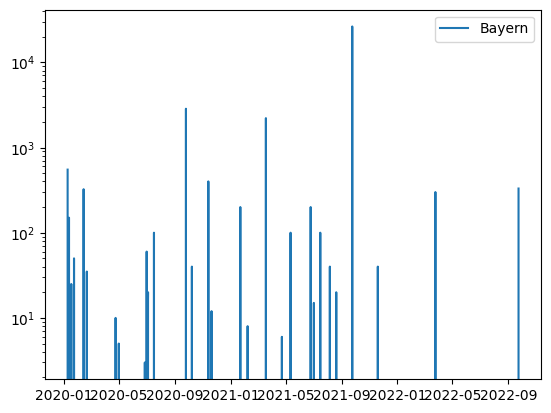

Hamburg 22 22


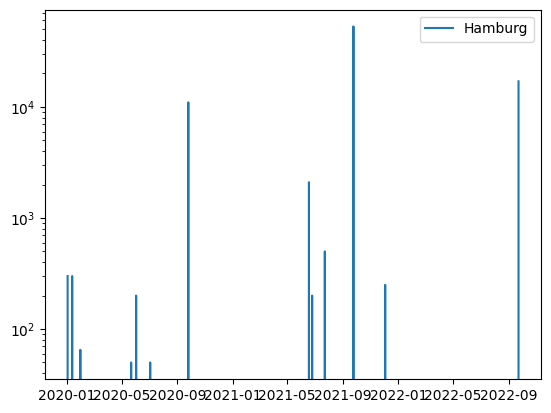

Hessen 31 19


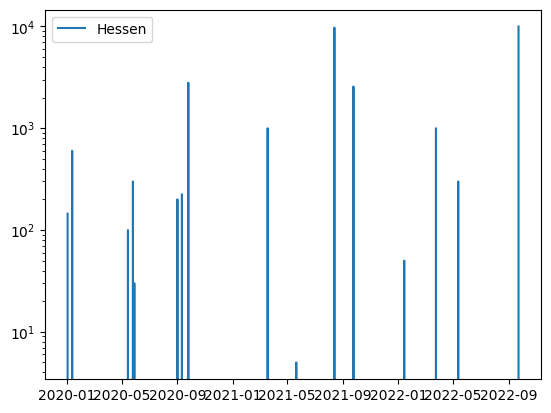

Rheinland-Pfalz 28 9


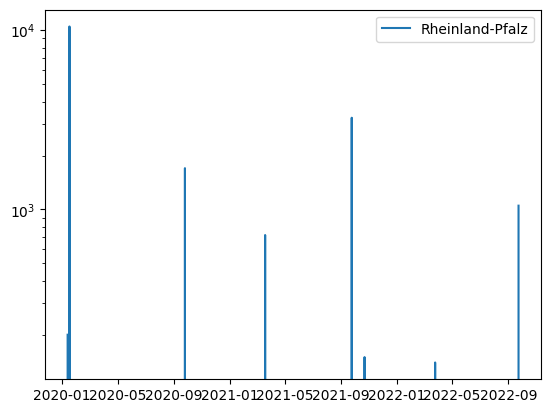

Schleswig-Holstein 29 18


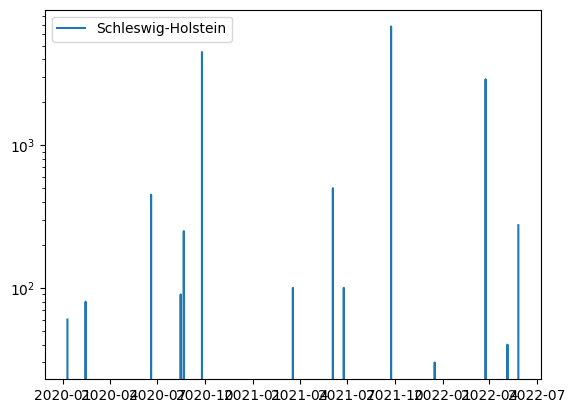

Saarland 7 6


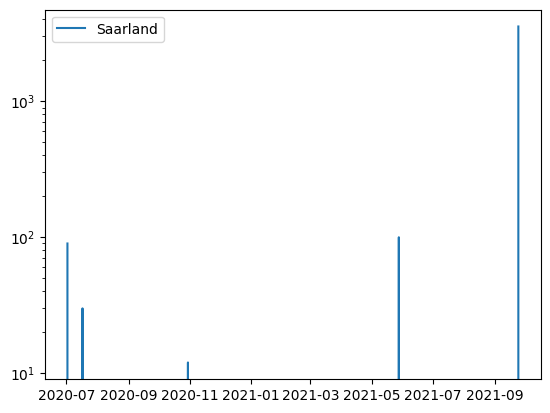

In [144]:
import matplotlib.pyplot as plt
import pandas as pd


def get_region_data(region: str) -> pd.DataFrame:
    region_df = protests[protests.admin1 == region]
    # group by date and fill dates without protests with 0
    region_df = (
        region_df.groupby("event_date")
        .sum("size")
        .reindex(
            pd.date_range(region_df.event_date.min(), region_df.event_date.max()),
            fill_value=0,
        )
    )
    return region_df


def plot_region(region: str):
    region_df = get_region_data(region)
    plt.plot(region_df.index, region_df["size"], label=region)
    plt.legend()
    plt.yscale("log")
    plt.show()


for region in protests.admin1.unique():
    n_protests = len(protests[protests.admin1 == region])
    n_protest_days = len(protests[protests.admin1 == region].event_date.unique())
    print(region, n_protests, n_protest_days)
    plot_region(region)

climate_and_protest
climate_not_protest


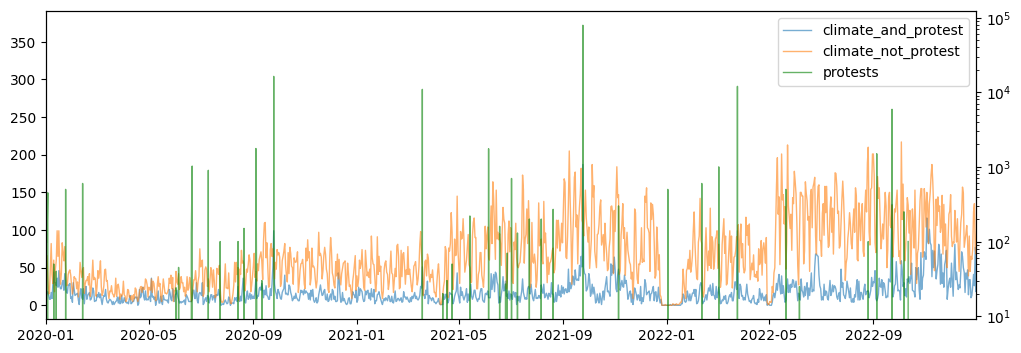

In [145]:
from src.models.synthetic_region import get_regional_count_df

queries = get_climate_queries()
ts = dict()
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
for k in ["climate_and_protest", "climate_not_protest"]:
    # get the article counts for each query
    ts_ = get_regional_count_df(
        region="Nordrhein-Westfalen", query_string=queries[k][0], source="mediacloud"
    )
    ts_ = ts_.set_index("date")
    ts[k] = ts_
    print(k)
    # plot the article counts
    ax.plot(ts_.index, ts_["count"], label=k, linewidth=1, alpha=0.6)
# get the protest counts for the region
nrw_protests = get_region_data("Nordrhein-Westfalen")
# plot the protest counts
ax2 = ax.twinx()
ax2.plot(
    nrw_protests.index,
    nrw_protests["size"],
    label="protests",
    color="green",
    linewidth=1,
    alpha=0.6,
)
ax2.set_yscale("log")
# merge the two legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
# set the x-axis range so we can see the full plot
ax.set_xlim(pd.Timestamp("2020-01-01"), pd.Timestamp("2022-12-31"))
plt.show()

In [167]:
def get_ts_features(ts, date, n_days):
    ts_ = ts.loc[date - pd.Timedelta(days=n_days) : date]
    diff = ts_.diff()
    diff2 = diff.diff()
    roll = ts_.rolling(7).mean()
    features = dict(
        ts=ts_,
        diff=diff,
        diff2=diff2,
        roll=roll,
    )
    return features


def get_ts_feature_values(k, ts, date, n_days):
    features = get_ts_features(ts, date, n_days)
    values = {}
    for f in features:
        for i in range(30):
            values[f"{k}_{f}_{i}"] = features[f].loc[
                date - pd.Timedelta(days=i), "count"
            ]
    return values


def get_features_for_date(date, n_days):
    row = dict(
        date=date,
        has_protest=nrw_protests.loc[date, "size"] > 0,
    )
    for k in ts:
        values = get_ts_feature_values(k, ts[k], date, n_days)
        row.update(values)
    return row


from tqdm.auto import tqdm

df = pd.DataFrame(
    [get_features_for_date(date, 30) for date in tqdm(nrw_protests.index)]
)
df.head()

  0%|          | 0/1015 [00:00<?, ?it/s]

,date,has_protest,climate_and_protest_ts_0,climate_and_protest_ts_1,climate_and_protest_ts_2,climate_and_protest_ts_3,climate_and_protest_ts_4,climate_and_protest_ts_5,climate_and_protest_ts_6,climate_and_protest_ts_7,...,climate_not_protest_roll_20,climate_not_protest_roll_21,climate_not_protest_roll_22,climate_not_protest_roll_23,climate_not_protest_roll_24,climate_not_protest_roll_25,climate_not_protest_roll_26,climate_not_protest_roll_27,climate_not_protest_roll_28,climate_not_protest_roll_29
0,2020-01-02,True,16,10,37,37,24,7,14,7,...,58.000000,57.571429,54.142857,54.142857,55.571429,NaN,NaN,NaN,NaN,NaN
1,2020-01-03,True,18,16,10,37,37,24,7,14,...,59.571429,58.000000,57.571429,54.142857,54.142857,NaN,NaN,NaN,NaN,NaN
2,2020-01-04,False,14,18,16,10,37,37,24,7,...,60.000000,59.571429,58.000000,57.571429,54.142857,NaN,NaN,NaN,NaN,NaN
3,2020-01-05,False,8,14,18,16,10,37,37,24,...,59.285714,60.000000,59.571429,58.000000,57.571429,NaN,NaN,NaN,NaN,NaN
4,2020-01-06,False,8,8,14,18,16,10,37,37,...,57.571429,59.285714,60.000000,59.571429,58.000000,NaN,NaN,NaN,NaN,NaN


In [171]:
df = pd.concat([df, pd.get_dummies(df["date"].dt.weekday, prefix="weekday")], axis=1)

In [174]:
df = df.drop(columns=df.columns[df.isna().any()])
df = df.drop(columns=["date"])

In [175]:
# train logistic regression model to predict whether there is a protest

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.5, shuffle=False)

from sklearn.linear_model import LogisticRegression

# give higher weight to the minority class
model = LogisticRegression(penalty="l1", solver="liblinear")
model.fit(train.drop("has_protest", axis=1), train["has_protest"])

from sklearn.metrics import classification_report

print(
    classification_report(
        test["has_protest"], model.predict(test.drop("has_protest", axis=1))
    )
)

              precision    recall  f1-score   support

       False       0.96      0.93      0.95       486
        True       0.11      0.18      0.13        22

    accuracy                           0.90       508
   macro avg       0.53      0.56      0.54       508
weighted avg       0.92      0.90      0.91       508

